<a href="https://colab.research.google.com/github/nooh1318/fire/blob/main/fireweek4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /kaggle/input/the-wildfire-dataset
⚠️ GPU is Unavailable!
Number of Classes: 2
Classes: ['nofire', 'fire']
Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.


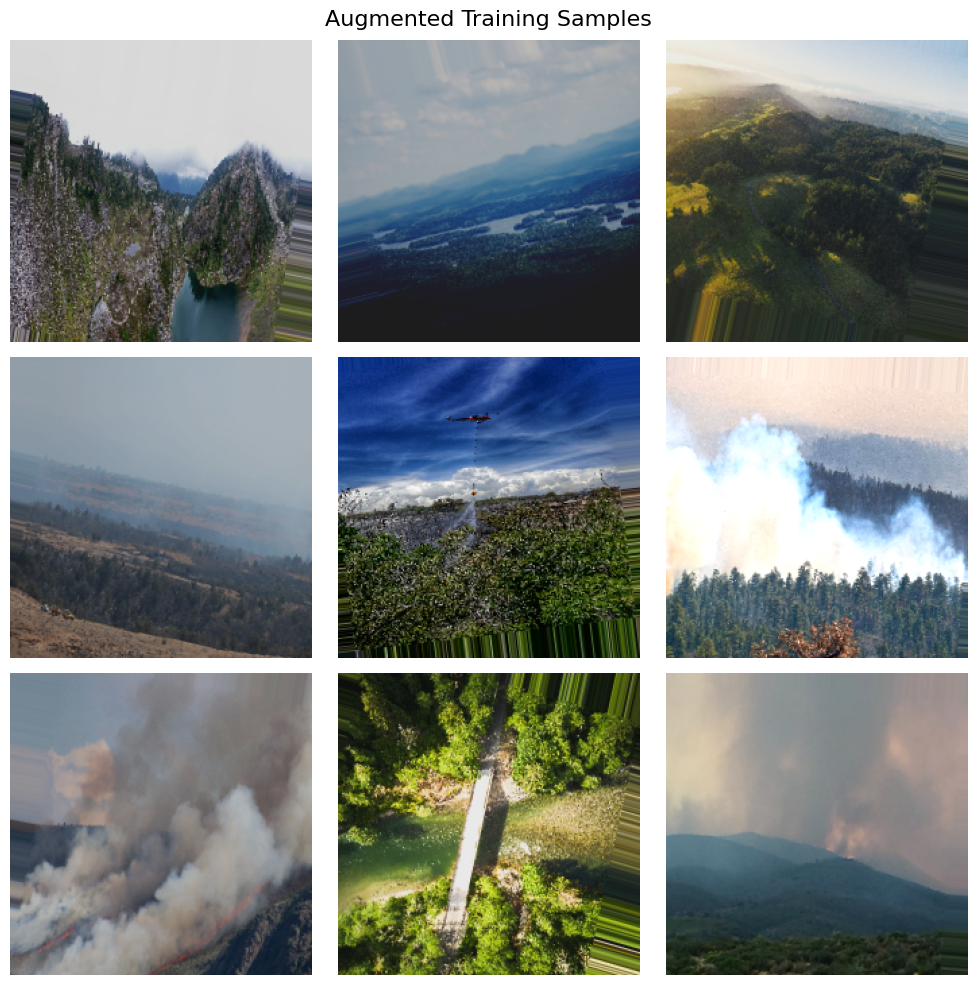

Epoch 1/7
 2/59 ━━━━━━━━━━━━━━━━━━━━ 7:50 8s/step - accuracy: 0.4062 - loss: 6.2887  

KeyboardInterrupt: 

In [7]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Download dataset
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")
print("Path to dataset files:", path)

# GPU check
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('✅ GPU is Available!')
else:
    print('⚠️ GPU is Unavailable!')

# Paths
train_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/train')
val_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/val')
test_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/test')

# Class info
classes = os.listdir(train_dir)
num_classes = len(classes)
print(f'Number of Classes: {num_classes}\nClasses: {classes}')

# Augmentation with more specific adjustments
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    channel_shift_range=20.0,    # Adjust color saturation
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# ✅ Visualize some augmented training images
augmented_images, _ = next(iter(train_data))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle("Augmented Training Samples", fontsize=16)
plt.tight_layout()
plt.show()

# ✅ Pre-trained Model (EfficientNetB0) for better generalization
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (don't train them)
base_model.trainable = False

# Model Definition with the pre-trained base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train the model with increased epochs
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=7  # Increased epochs for better training
)

# ✅ Show training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.legend()

plt.show()
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Download dataset
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")
print("Path to dataset files:", path)

# GPU check
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('✅ GPU is Available!')
else:
    print('⚠️ GPU is Unavailable!')

# Paths
train_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/train')
val_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/val')
test_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/test')

# Class info
classes = os.listdir(train_dir)
num_classes = len(classes)
print(f'Number of Classes: {num_classes}\nClasses: {classes}')

# Augmentation with more specific adjustments
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    channel_shift_range=20.0,    # Adjust color saturation
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# ✅ Visualize some augmented training images
augmented_images, _ = next(iter(train_data))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle("Augmented Training Samples", fontsize=16)
plt.tight_layout()
plt.show()

# ✅ Pre-trained Model (EfficientNetB0) for better generalization
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (don't train them)
base_model.trainable = False

# Model Definition with the pre-trained base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train the model with increased epochs
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=7  # Increased epochs for better training
)

# ✅ Show training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.legend()

plt.show()

# ✅ Test prediction
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    shuffle=True,
    class_mode='categorical'
)

# Predict and visualize
class_labels = list(test_data.class_indices.keys())

for i in range(5):
    img, label = next(iter(test_data))  # ✅ Fix the .next() issue
    prediction = model.predict(img)
    predicted_class = class_labels[np.argmax(prediction)]

    plt.imshow(img[0])
    plt.title(f'Predicted: {predicted_class}\nActual: {class_labels[np.argmax(label)]}')
    plt.axis('off')
    plt.show()



# Get class labels (ensure they match your dataset)
class_labels = list(train_data.class_indices.keys())

# Test your custom image
predict_custom_image(
    img_path="your_image.jpg",  # Replace with your image path
    model=model,
    class_labels=class_labels
)

# ✅ Test prediction
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    shuffle=True,
    class_mode='categorical'
)

# Predict and visualize
class_labels = list(test_data.class_indices.keys())

for i in range(5):
    img, label = next(iter(test_data))  # ✅ Fix the .next() issue
    prediction = model.predict(img)
    predicted_class = class_labels[np.argmax(prediction)]

    plt.imshow(img[0])
    plt.title(f'Predicted: {predicted_class}\nActual: {class_labels[np.argmax(label)]}')
    plt.axis('off')
    plt.show()



